# import libraries and data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('emails.csv')

In [3]:
data.shape

(5728, 2)

In [4]:
data.isnull().sum()

text    0
spam    0
dtype: int64

In [5]:
data.duplicated().sum()

33

In [6]:
data = data.drop_duplicates(keep='last')

In [7]:
data.head(1)

,text,spam
0,Subject: naturally irresistible your corporate...,1


In [8]:
data.spam.value_counts()

spam
0    4327
1    1368
Name: count, dtype: int64

# take the labels and the text 

In [9]:
x = data['text'].values
y = data['spam'].values

In [10]:
x

array(["Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : y

# remove stopwords from text

In [11]:
from nltk.corpus import stopwords

In [12]:
stop  = stopwords.words("english")

In [13]:
def remove_stop(sent):
    text = ' '.join([word for word in sent.split() if word not in stop])
    return text
        

In [14]:
text = []
for i in x:
    new = remove_stop(i)
    text.append(new)
    

In [15]:
x = np.array(text)

# split in train and test

In [16]:
from sklearn.model_selection import train_test_split as tt
x_train,x_test,y_train,y_test = tt(x,y,test_size=0.2)

# tensorflow approach 

# Tokenize the words

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
token = Tokenizer(num_words=30000,oov_token = 'oov_tok')

In [19]:
token.fit_on_texts(x_train)

In [20]:
len(token.word_index)

33515

In [21]:
np.argmax(x_train)

410

In [22]:
size_ = len(x_train[4453])

# make sequences and pad them

In [23]:
train_sequences = token.texts_to_sequences(x_train)
training_padded = pad_sequences(train_sequences, maxlen=size_, padding='post', truncating='post')

In [24]:
test_sequences = token.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, maxlen=size_, padding='post', truncating='post')

# create the input that the tensorflow expects

In [25]:
train_x = np.array(training_padded)
train_y = np.array(y_train)


test_x = np.array(test_padded)
test_y = np.array(y_test)

# create a callback for the best weights

In [27]:

import tensorflow as tf

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_best.h5',
                                                 save_weights_only=True,
                                                 verbose=1)

# now lets make the model

In [28]:


from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import *

In [29]:
model = Sequential()

model.add(Embedding(30000,output_dim=20,input_length=size_))
model.add(GlobalAveragePooling1D())
model.add(Dense(70,'relu',kernel_regularizer='l1'))
model.add(BatchNormalization())
model.add(Dense(1,'sigmoid',kernel_regularizer='l1'))

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 768, 20)           600000    
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 70)                1470      
                                                                 
 batch_normalization (Batch  (None, 70)                280       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 71        
                                                                 
Total params: 601821 (2.30 MB)
Trainable params: 601681

In [30]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
hist = model.fit(train_x,train_y,epochs=18,validation_data=(test_x,test_y),callbacks=[cp_callback])

Epoch 1/18


139/143 [============================>.] - ETA: 0s - loss: 1.6518 - accuracy: 0.7579
Epoch 1: saving model to model_best.h5
143/143 [==============================] - 6s 19ms/step - loss: 1.6358 - accuracy: 0.7572 - val_loss: 1.0273 - val_accuracy: 0.7647
Epoch 2/18
139/143 [============================>.] - ETA: 0s - loss: 0.6010 - accuracy: 0.8914
Epoch 2: saving model to model_best.h5
143/143 [==============================] - 1s 10ms/step - loss: 0.5966 - accuracy: 0.8929 - val_loss: 0.6849 - val_accuracy: 0.7647
Epoch 3/18
138/143 [===========================>..] - ETA: 0s - loss: 0.3763 - accuracy: 0.9574
Epoch 3: saving model to model_best.h5
143/143 [==============================] - 2s 13ms/step - loss: 0.3758 - accuracy: 0.9565 - val_loss: 0.5572 - val_accuracy: 0.7867
Epoch 4/18
142/143 [============================>.] - ETA: 0s - loss: 0.3041 - accuracy: 0.9773
Epoch 4: saving model to model_best.h5
143/143 [==============================] - 2s 12ms/step - loss

In [33]:
model.load_weights('model_best.h5')

# plot history 

In [34]:
keys = list(hist.history.keys())
keys

['loss', 'accuracy', 'val_loss', 'val_accuracy']

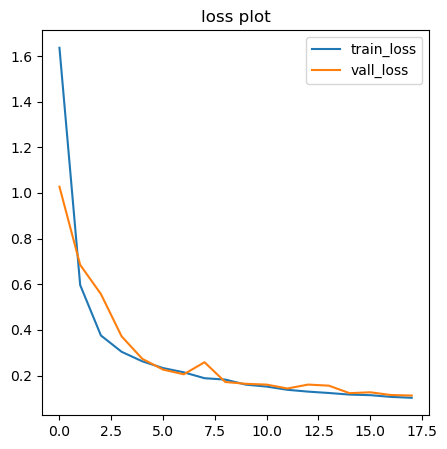

In [35]:
import matplotlib.pyplot as plt


plt.figure(figsize=(5,5))
plt.plot(hist.history[keys[0]],label='train_loss')
plt.plot(hist.history[keys[2]],label='vall_loss')
plt.legend()
plt.title('loss plot')
plt.show()

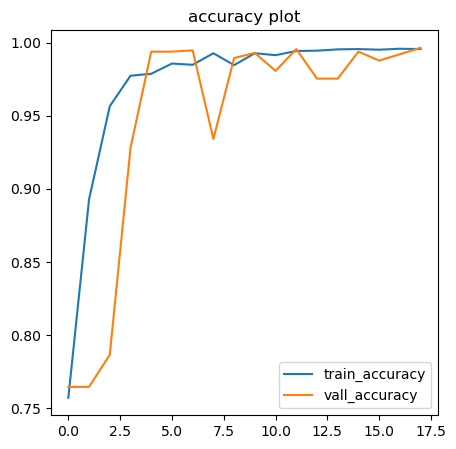

In [36]:
plt.figure(figsize=(5,5))
plt.plot(hist.history[keys[1]],label='train_accuracy')
plt.plot(hist.history[keys[3]],label='vall_accuracy')
plt.legend()
plt.title('accuracy plot')
plt.show()

In [37]:


y_pred = model.predict(test_x)

36/36 [==============================] - 0s 3ms/step


In [38]:
y_pred = y_pred.flatten()

In [39]:
preds = []
for i in y_pred:
    if i > 0.5 :
        preds.append(1)
    else:
        preds.append(0)

In [40]:
from sklearn.metrics import accuracy_score,confusion_matrix as sm

print(accuracy_score(preds,test_y))

0.9964881474978051


<Axes: >

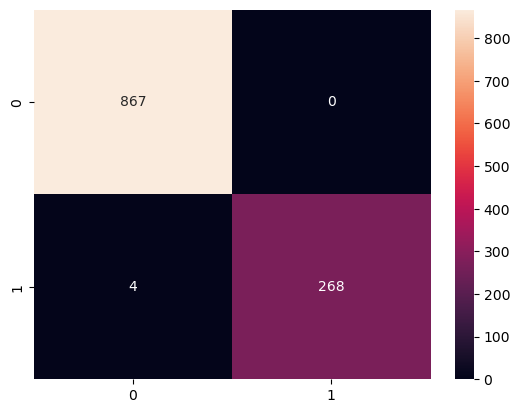

In [41]:
import seaborn as sns

sns.heatmap(sm(preds,test_y),annot=True,fmt='.0f')

# Naive Bayes classifier

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vect  = TfidfVectorizer()


x_train_v=vect.fit_transform(x_train)
x_test_v=vect.transform(x_test)

In [43]:
from sklearn.naive_bayes import GaussianNB
Gnb=GaussianNB()

In [44]:
Gnb.fit(x_train_v.toarray(),y_train)

GaussianNB()

In [45]:
y_pred = Gnb.predict(x_test_v.toarray())

In [46]:
preds = []
for i in y_pred:
    if i > 0.5 :
        preds.append(1)
    else:
        preds.append(0)

In [47]:
print(accuracy_score(preds,y_test))

0.9604916593503073


<Axes: >

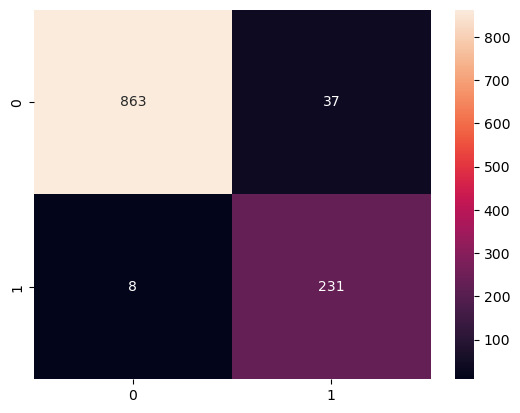

In [48]:

sns.heatmap(sm(preds,y_test),annot=True,fmt='.0f')

# tensorflow model works best so we will keep it : 

In [49]:

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# predidction in custom test : 

In [61]:
mails = ["""
Subject: Exclusive Limited-Time Offer Inside!

Body:
Unlock unbelievable savings now! Act fast to claim your free gift. Don't miss out on this incredible deal!""",
"""Subject: Upcoming Team Building Event

Body:
Dear [Recipient],

I hope this message finds you well. We're excited to announce an upcoming team-building event
on [date] at [location]. Your participation will be highly valued. Looking forward to seeing you there!"""]

In [62]:
test = token.texts_to_sequences(mails)
test = pad_sequences(test, maxlen=size_, padding='post', truncating='post')

In [63]:
test = np.array(test)

In [64]:
mail_preds = model.predict(test)

1/1 [==============================] - 0s 47ms/step


In [65]:
mail_preds

array([[0.95730877],
       [0.3150717 ]], dtype=float32)

### model predicted perfectly 